#### setup environment

In [1]:
import sys

sys.executable

'/home/zb609/anaconda2/envs/python-mm-27/bin/python'

In [5]:
from os import path, environ
import numpy as np
from matplotlib import pyplot as plt

from madminer.sampling import SampleAugmenter, benchmark, benchmarks
from madminer.ml import ParameterizedRatioEstimator

from batch_madminer_event_runner import EventRunner
%matplotlib inline

working_dir = '/scratch/zb609/madminer_data_higgs4l' # cluster
# working_dir = '/scratch/madminer_data' # my computer

er = EventRunner(working_dir)

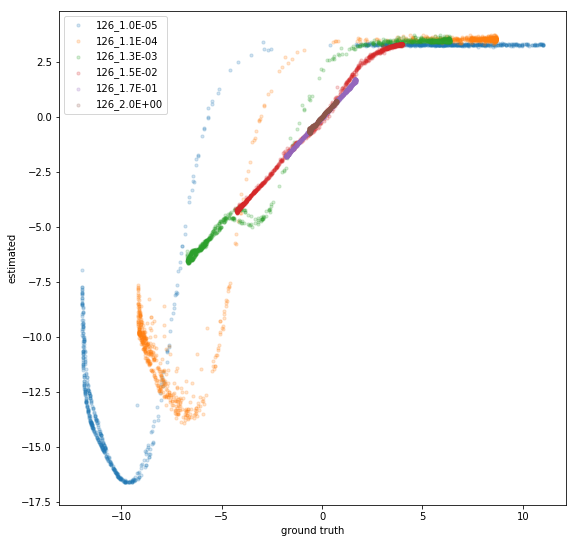

In [6]:
# load sample augmenter
n_test_events = 1000
miner_data_shuffled_path = path.join(er.data_dir, 'data/miner_lhe_data_shuffled.h5')
sa = SampleAugmenter(miner_data_shuffled_path)
n_benchmarks = len(er.theta0_benchmarks)
theta0_benchmarks_sublist = [er.theta0_benchmarks[0], er.theta0_benchmarks[n_benchmarks/2], er.theta0_benchmarks[-1]]
theta0_benchmarks_sublist = er.theta0_benchmarks[0::4]
colors = ['b', 'g', 'r']
fig = plt.figure(figsize=(20,20))
fig2 = plt.figure(figsize=(15,25))

ax1 = fig.add_subplot(221)

for idx, theta0_benchmark in enumerate(theta0_benchmarks_sublist):
    test_result = sa.sample_train_ratio(
        theta0=benchmark(theta0_benchmark.name),
        theta1=benchmark(er.theta1_benchmark.name),
        n_samples=n_test_events,
        sample_only_from_closest_benchmark=True,
        partition='test',
        folder=path.join(er.data_dir, 'data/samples'),
        filename='test_truth',
    )
    x, theta0, theta1, y, r_xz, t_xz, n_effective = test_result
    m4l = np.log(x[:,-1])
    ground_truth_log_likelihood_ratio = np.log(r_xz)

    ratio_estimator = ParameterizedRatioEstimator(n_hidden=(100, 100))
    ratio_estimator.load(path.join(er.data_dir, 'models/alice'))

    estimated_log_likelihood_ratio, _ = ratio_estimator.evaluate_log_likelihood_ratio(
        # x=path.join(er.data_dir, 'data/samples/x_test_truth.npy'),
        x=x,
        theta=theta0,
        test_all_combinations=False
    )

    ax1.scatter(ground_truth_log_likelihood_ratio, estimated_log_likelihood_ratio, s=10, alpha=0.2, label=theta0_benchmark.name)
    ax2 = fig2.add_subplot(len(theta0_benchmarks_sublist)/2 + 1, 2, 1+idx)
    ax2.scatter(m4l, ground_truth_log_likelihood_ratio, s=10, alpha=0.2, c='g', label='truth')
    ax2.scatter(m4l, estimated_log_likelihood_ratio, s=10, alpha=0.2, c='b', label='estimated')
    ax2.set_title(theta0_benchmark.name)
    ax2.set_xlabel('log(m4l)')
    ax2.set_ylabel('log likelihood ratio')
    ax2.legend()

ax1.set_xlabel('ground truth')
ax1.set_ylabel('estimated')
ax1.legend()
plt.close(fig)
plt.close(fig2)
fig


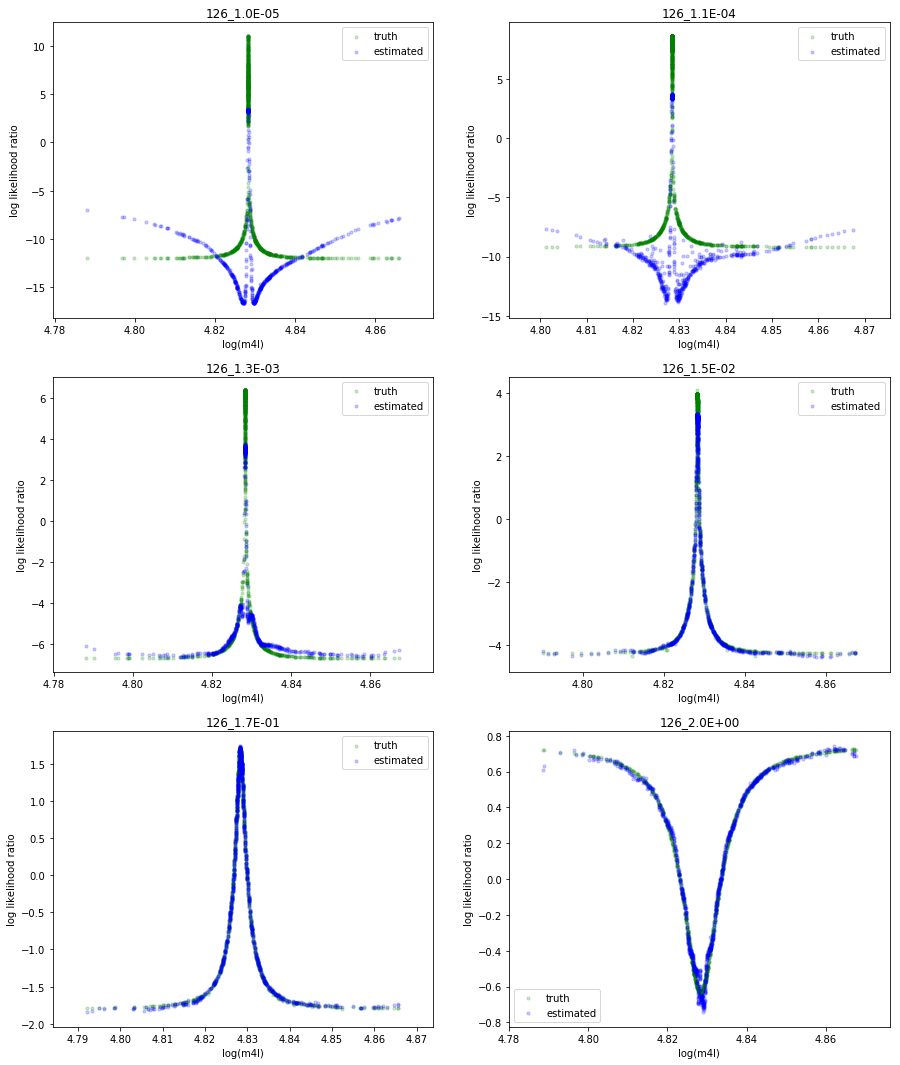

In [7]:
fig2

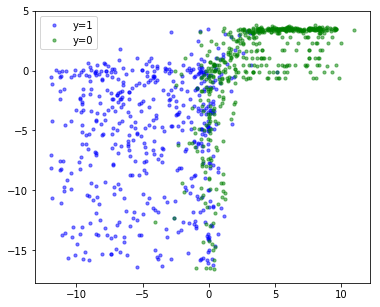

In [8]:
# plot two series based on values of y
test_result = sa.sample_train_ratio(
    theta0=benchmarks([b.name for b in er.theta0_benchmarks]),
    theta1=benchmark(er.theta1_benchmark.name),
    n_samples=n_test_events,
    sample_only_from_closest_benchmark=True,
    partition='test',
    folder=path.join(er.data_dir, 'data/samples'),
    filename='test_truth',
)
x, theta0, theta1, y, r_xz, t_xz, n_effective = test_result

ground_truth_log_likelihood_ratio_y_1 = np.log(r_xz[np.array(y[:, 0], dtype=bool)])
ground_truth_log_likelihood_ratio_y_0 = np.log(r_xz[np.array(0**y[:, 0], dtype=bool)])
x_y_1 = x[np.array(y[:, 0], dtype=bool)]
x_y_0 = x[np.array(0**y[:, 0], dtype=bool)]

ratio_estimator = ParameterizedRatioEstimator(n_hidden=(100, 100))
ratio_estimator.load(path.join(er.data_dir, 'models/alice'))

estimated_log_likelihood_ratio_y_1, _ = ratio_estimator.evaluate_log_likelihood_ratio(
    # x=path.join(er.data_dir, 'data/samples/x_test_truth.npy'),
    x=x_y_1,
    theta=theta0,
    test_all_combinations=False
)

estimated_log_likelihood_ratio_y_0, _ = ratio_estimator.evaluate_log_likelihood_ratio(
    # x=path.join(er.data_dir, 'data/samples/x_test_truth.npy'),
    x=x_y_0,
    theta=theta0,
    test_all_combinations=False
)

fig = plt.figure(figsize=(6, 5))
ax1 = fig.add_subplot(111)
ax1.scatter(ground_truth_log_likelihood_ratio_y_1, estimated_log_likelihood_ratio_y_1, s=10, alpha=0.5, c='b', label='y=1')
ax1.scatter(ground_truth_log_likelihood_ratio_y_0, estimated_log_likelihood_ratio_y_0, s=10, alpha=0.5, c='g', label='y=0')
plt.legend()
plt.show()